In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import nltk
import tqdm
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
import gensim.downloader as api
from collections.abc import Collection
from gensim.models import KeyedVectors
from torch.utils.data import Dataset
import torch
import os
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.optim import Adam

In [3]:
data = pd.read_csv("Train_rev1.csv", index_col=None)

print(data.shape)
data.head(2)

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [4]:
seed = 0
data_train_val, data_test = train_test_split(data, test_size=0.2, random_state=seed)
data, data_val = train_test_split(data_train_val, test_size=0.2, random_state=seed)


In [5]:
avg_word_count = data['FullDescription'].apply(lambda x: len(x.split())).mean() 
avg_word_count

245.1319812832347

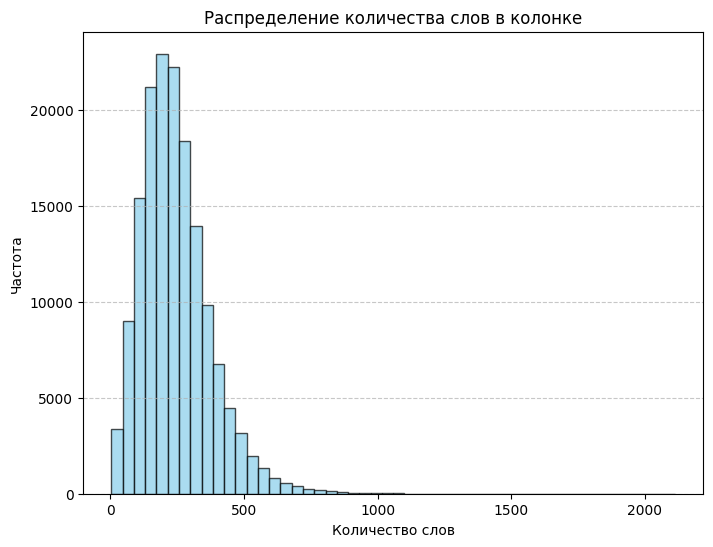

In [13]:
plt.figure(figsize=(8, 6))
plt.hist(data['FullDescription'].apply(lambda x: len(x.split())), bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Распределение количества слов в колонке')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

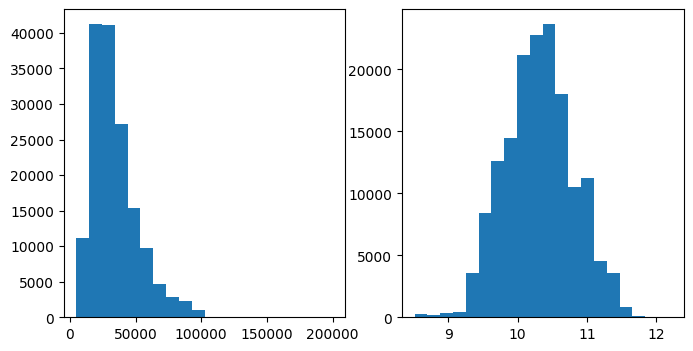

In [6]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20);


In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data.sample(3)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
67971,68780027,Accessories Designer,Successful company requires an experienced acc...,North West,North West London,NaN,permanent,Dune Recruitment,Retail Jobs,"From 20,000 to 25,000 per annum c20k-25k plus ...",22500,retailchoice.com,10.021315
118056,69804633,Financial Software Customer Support / Helpdesk,Working for a software house providing helpdes...,Reading Berkshire South East,Reading,NaN,permanent,Forest Personnel Limited,Customer Services Jobs,"From 16,000 to 17,000 per annum c16k / 8ph ini...",16500,totaljobs.com,9.711176
189608,71714474,Care Worker,A luxury provider of care related services to ...,Lymington,Lymington,NaN,contract,NaN,Other/General Jobs,8.00-9.50ph,16800,hays.co.uk,9.729194


In [8]:
data.fillna({"Title": "NaN"}, inplace=True)
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in ("FullDescription", "Title"):
    tmp = [" ".join(tokenizer.tokenize(x)).lower() for x in tqdm.tqdm(data[col])]
    data[col] = tmp


  1%|          | 1106/156651 [00:00<00:14, 11059.46it/s]

100%|██████████| 156651/156651 [00:00<00:00, 400249.95it/s]


In [7]:
data['FullDescription'].map(len).max()

14645

In [8]:
Counter(data["Company"])

Counter({nan: 20706,
         'UKStaffsearch': 3233,
         'CVbrowser': 1880,
         'London4Jobs': 1496,
         'Hays': 1162,
         'JAM Recruitment Ltd': 744,
         'Office Angels': 606,
         'Jobsite Jobs': 597,
         'Perfect Placement': 576,
         'ARRAY': 537,
         'Matchtech Group plc.': 535,
         'JOBG8': 513,
         'Penguin Recruitment': 499,
         'Randstad': 482,
         'Michael Page Finance': 437,
         'Adecco': 433,
         'Adecco Group': 375,
         'BMS Sales Specialists LLP': 363,
         'Page Personnel Finance': 341,
         'COREcruitment International': 337,
         'Michael Page Sales': 325,
         'Capita Resourcing': 311,
         'Matchtech': 301,
         'Rise Technical Recruitment Ltd': 299,
         'Huxley Associates': 286,
         'Experis IT': 282,
         'Brookstreet UK': 276,
         'Support Services Group': 272,
         'Interaction Recruitment': 270,
         'ATA Recruitment': 265,
         'S

In [9]:
data[categorical_columns] = data[categorical_columns].fillna("NaN")

top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))

recognized_companies = set(top_companies)

data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))


DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [10]:
wv = api.load("word2vec-google-news-300")
print(type(wv))
print(wv.get_vector("map").shape)
print(wv.has_index_for("map"))




<class 'gensim.models.keyedvectors.KeyedVectors'>
(300,)
True


In [11]:
take_first_n = 1_000

# Весь датасет не влезет в RAM, будем бить на батчи
# Возьмите subset = data - и увидите, что не помещается
subset = data.iloc[:100].copy()

for col in ("FullDescription", "Title"):
    new_data = [
        np.stack(
            [
                wv.get_vector(x)
                for x in tokens.split()[:take_first_n]
                if wv.has_index_for(x)
            ]
        )
        for tokens in tqdm.tqdm(subset[col])
    ]
    subset[f"emb_{col}"] = new_data


100%|██████████| 100/100 [00:00<00:00, 35560.02it/s]


In [12]:
# тексты разной длины
subset["emb_FullDescription"].map(lambda x: x.shape)


104939    (108, 300)
45543     (112, 300)
164172    (232, 300)
20726     (442, 300)
194925     (93, 300)
             ...    
174632    (289, 300)
175751    (155, 300)
183638    (271, 300)
208091    (171, 300)
198073    (300, 300)
Name: emb_FullDescription, Length: 100, dtype: object

In [13]:
# Возьмем </s> - только проверим, что его нет в наших текстах
wv.index_to_key[:10]

# Output
# ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']


['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [13]:
assert 0 == data["Title"].map(lambda tokens: "</s>" in tokens).sum()
assert 0 == data["FullDescription"].map(lambda tokens: "</s>" in tokens).sum()


In [14]:
# Эту функцию дальше не будем использовать, но она демонстрирует идею паддинга
def pad_sequence(series: pd.Series, pad_length: int, pad_token: str = "</s>"):
    return series.map(
        lambda tokens: " ".join(
            tokens.split() + [pad_token] * max(0, pad_length - len(tokens.split()))
        )
    )


In [15]:
pad_sequence(subset["Title"], 15).head(15)


104939    nursery manager </s> </s> </s> </s> </s> </s> ...
45543     retail advisor – gateshead cameron walk ( part...
164172    finance manager london </s> </s> </s> </s> </s...
20726     weekend showroom host , high wycombe , motor t...
194925    registered nurses ( rgn ' s rmn ' s & rnld ' s...
222927    field sales executive portable appliance / ele...
206627    real estate partner </s> </s> </s> </s> </s> <...
127166    clinical advisor patient monitoring </s> </s> ...
123545    retail sales consultant </s> </s> </s> </s> </...
42842     senior systems analyst </s> </s> </s> </s> </s...
60993     digital graphic design manager asda </s> </s> ...
32378     materials planner / stock controller / buyer <...
122579    cnc machine operator </s> </s> </s> </s> </s> ...
150341    hr business partner cipd charitable organisati...
80759     evening cleaner hilton birmingham metropole </...
Name: Title, dtype: object

In [16]:

def pad_or_trim_to_length(
    pad_length: int, vectors: list[np.ndarray], pad_vector: np.ndarray
):
    assert pad_vector.ndim == 1
    # допаддим слева, а если превысили - обрежем с конца
    vectors = vectors[:pad_length] + [pad_vector] * max(0, pad_length - len(vectors))
    return np.stack(vectors)


In [17]:
def seq_to_emb(
    sentences: Collection[str], wv: KeyedVectors, pad_length: int, pad_token: str = "</s>"
):
    rv = []
    
    for sentence in sentences:
        sentence_embeddings = []
        
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_length(
            pad_length, sentence_embeddings, wv.get_vector(pad_token)
        )
        rv.append(np.stack(sentence_embeddings))
        
    return np.stack(rv)


In [18]:
seq_to_emb(subset["Title"], wv, 50).shape
# Output
# (100, 50, 300)


(100, 50, 300)

In [19]:
print(
    "Максимальное количество токенов в колонке 'Title':",
    data["Title"].map(lambda x: x.split()).map(len).max(),
)
print(
    "Максимальное количество токенов в колонке 'FullDescription':",
    data["FullDescription"].map(lambda x: x.split()).map(len).max(),
)

# Output
# Максимальное количество токенов в колонке 'Title': 40
# Максимальное количество токенов в колонке 'FullDescription': 2317


Максимальное количество токенов в колонке 'Title': 40
Максимальное количество токенов в колонке 'FullDescription': 2317


In [20]:

class CvTextDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        pad_title_len: int,
        pad_desc_len: int,
        wv: KeyedVectors,
        categorical_vectorizer: DictVectorizer,
    ):
        # Далее будут те коды препроцессинга, что писали ранее
        self.target_column = "Log1pSalary"
        data[self.target_column] = np.log1p(data["SalaryNormalized"]).astype("float32")

        # Кат. фичи: заполнить пропуски, взять топ популярных компаний и OHE
        data[categorical_columns] = data[categorical_columns].fillna("NaN")
        top_companies, _ = zip(*Counter(data["Company"]).most_common(1000))
        recognized_companies = set(top_companies)
        data["Company"] = data["Company"].apply(
            lambda comp: comp if comp in recognized_companies else "Other"
        )
        self.categorical_vectorizer = categorical_vectorizer

        # Текстовые фичи: токенизация
        self.text_columns = ["Title", "FullDescription"]
        data.fillna({k: "NaN" for k in self.text_columns}, inplace=True)
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        for col in self.text_columns:
            tmp = [
                " ".join(tokenizer.tokenize(x)).lower() for x in tqdm.tqdm(data[col])
            ]
            data[col] = tmp
        self.pad_len_for_column = {
            "Title": pad_title_len,
            "FullDescription": pad_desc_len,
        }

        self.wv = wv
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor, float]:
        one_row = self.data.iloc[index]
        target = one_row[self.target_column]
        rv = {}
        # Сначала две текстовые колонки, потом категориальные
        for one_feature in self.text_columns:
            rv[one_feature] = torch.from_numpy(
                seq_to_emb(
                    [one_row[one_feature]],
                    wv=self.wv,
                    pad_length=self.pad_len_for_column[one_feature],
                )
            ).squeeze(0)
        for one_feature in categorical_columns:
            rv[one_feature] = torch.from_numpy(
                self.categorical_vectorizer.transform(
                    {one_feature: one_row[one_feature]}
                )
            ).squeeze(0)
        rv[self.target_column] = target
        return rv


In [21]:
train_dataset = CvTextDataset(
    data,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
val_dataset = CvTextDataset(
    data_val,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
test_dataset = CvTextDataset(
    data_test,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)


  0%|          | 0/156651 [00:00<?, ?it/s]

100%|██████████| 48954/48954 [00:04<00:00, 11368.08it/s]


In [22]:
print(len(test_dataset))

x = test_dataset[0]

print(type(x["Title"]), type(x["FullDescription"]))
print(
    x["Title"].shape,
    x["FullDescription"].shape,
    x["Company"].shape,
    x["Log1pSalary"].shape,
)


48954
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([40, 300]) torch.Size([2317, 300]) torch.Size([3403]) ()


In [23]:
x.keys()

# Output:
# dict_keys(['Title', 'FullDescription', 'Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'Log1pSalary'])


dict_keys(['Title', 'FullDescription', 'Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'Log1pSalary'])

In [24]:


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)

def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

enable_determinism()
fix_seeds(0)


In [25]:
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=False,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

# Рисуем размерности выхода
[x.shape for x in next(iter(test_loader)).values()]


[torch.Size([64, 40, 300]),
 torch.Size([64, 2317, 300]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64])]

In [27]:

filter_sizes = [2, 3, 4]
num_filters = 2

class TextCnn(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 300
        self.text_filters = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(emb_size, num_filters, kernel_size=filter_sizes[i]),
                    nn.ReLU(),
                )
                for i in range(len(filter_sizes))
            ]
        )
        self.cat_network = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(len(categorical_vectorizer.vocabulary_), num_filters),
                    nn.ReLU(),
                )
                for _ in range(len(categorical_columns))
            ]
        )
        self.fc = nn.Linear(
            num_filters
            * (len(filter_sizes) * len(text_columns) + len(categorical_columns)),
            1,
        )

    def forward(self, data: dict[str, torch.Tensor]):
        to_fc = []
        
        for key in text_columns:
            x = data[key]
            rv = []
            
            for f in self.text_filters:
                # Свертка - выдаст [(bs, 2, n - 1), (bs, 2, n - 2), (bs, 2, n - 3)]
                result = f(x.permute((0, 2, 1)))
                # MaxPooling вдоль предложения - даст [(bs, 2), (bs, 2), (bs, 2)]
                result = torch.max(result, dim=2)[0]
                rv.append(result)
                
            x = torch.concat(rv, dim=1)
            to_fc.append(x)

        for i, key in enumerate(categorical_columns):
            x = data[key]
            x = self.cat_network[i](x)
            to_fc.append(x)

        x = torch.hstack(to_fc)
        x = self.fc(x).squeeze(1)
        return x


In [28]:
model = TextCnn()
model(next(iter(test_loader))).shape

# Output:
# torch.Size([64])


torch.Size([64])

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [30]:
device

device(type='cuda')

In [32]:
loss_fn = F.l1_loss

@torch.no_grad
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    
    for x in loader:
        x = {k: v.to(device) for k, v in x.items()}
        pred = model(x)
        loss = loss + loss_fn(pred, x[TARGET_COLUMN])
        
    model.train()
    return (loss / len(loader)).item()

def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    wandb.watch(model, criterion=loss_fn, log="parameters", log_freq=100)
    
    for _ in range(n_epochs):
        for x in tqdm.tqdm(train_loader):
            x = {k: v.to(device) for k, v in x.items()}
            pred = model(x)
            loss = loss_fn(pred, x[TARGET_COLUMN])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"loss": loss.item()})
        wandb.log({"val_loss": loss_on_dataset(model, val_loader, device)})
    return optimizer


In [33]:
!wandb login cc603ae0565bbbfce5cc5b068a9bddabb8950920

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [34]:
wandb.init(project="start-dl--lesson-6")
train_loop(model, train_loader, val_loader, device)


wandb: Currently logged in as: theotheo46 (theotheo46-trs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 2448/2448 [06:43<00:00,  6.06it/s]


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [35]:
# Подсчитаем, насколько модель ошибается на test датасете
model.to(device).eval()
losses = []

for x in tqdm.tqdm(test_loader):
    x = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        pred = model(x)
        
    for i in range(pred.shape[0]):
        losses.append((pred - x[TARGET_COLUMN])[i].item())


100%|██████████| 765/765 [02:04<00:00,  6.16it/s]


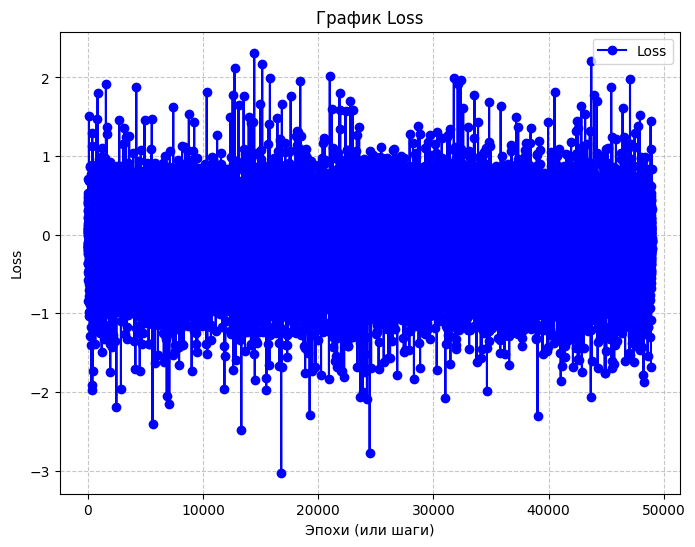

In [36]:
plt.figure(figsize=(8, 6))  # Задаем размер графика
plt.plot(losses, marker='o', linestyle='-', color='b', label='Loss')  # Строим график
plt.title('График Loss')  # Заголовок графика
plt.xlabel('Эпохи (или шаги)')  # Подпись оси X
plt.ylabel('Loss')  # Подпись оси Y
plt.grid(True, linestyle='--', alpha=0.7)  # Включаем сетку
plt.legend()  # Добавляем легенду
plt.show()  # Показываем график

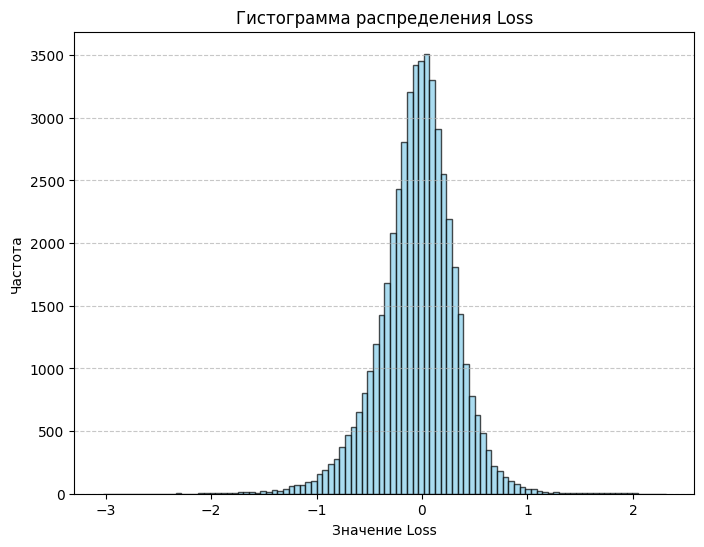

In [39]:
plt.figure(figsize=(8, 6))  # Задаем размер графика
plt.hist(losses, bins=100, edgecolor='black', color='skyblue', alpha=0.7)  # Строим гистограмму
plt.title('Гистограмма распределения Loss')  # Заголовок графика
plt.xlabel('Значение Loss')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Включаем сетку по оси Y
plt.show()  # Показываем график